## Text Classification


### The Data

The dataset below is from [kaggle]() and contains a dataset named "mtsamples.csv" containing medical transcriptions and their corresponding medical specialties.


In [3]:
# !pip install --upgrade nltk
# !pip install xgboost
# !pip install wordcloud
# !pip install transformers datasets torch scikit-learn
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('omw-1.4')


## Understand and Explore the Dataset
First, load and inspect the dataset:

In [200]:
df = pd.read_csv('C:\\Users\\mrbed\\Capstone\\mtsamples.csv')

In [202]:
print(df.columns)
df.head()

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [204]:
import warnings
warnings.filterwarnings('ignore')

## Text Preprocessing:
Initial steps included lowercasing, removal of punctuation, and elimination of stop words. Tokenization and lemmatization have been successfully implemented using the Punkt tokenizer.

In [206]:
# Drop rows with missing transcription
df = df.dropna(subset=['transcription'])

# Drop unnecessary columns
df = df[['medical_specialty', 'transcription']]
df.fillna('Unknown', inplace=True)

## Data Visualization
Visualize the distribution of specialties.


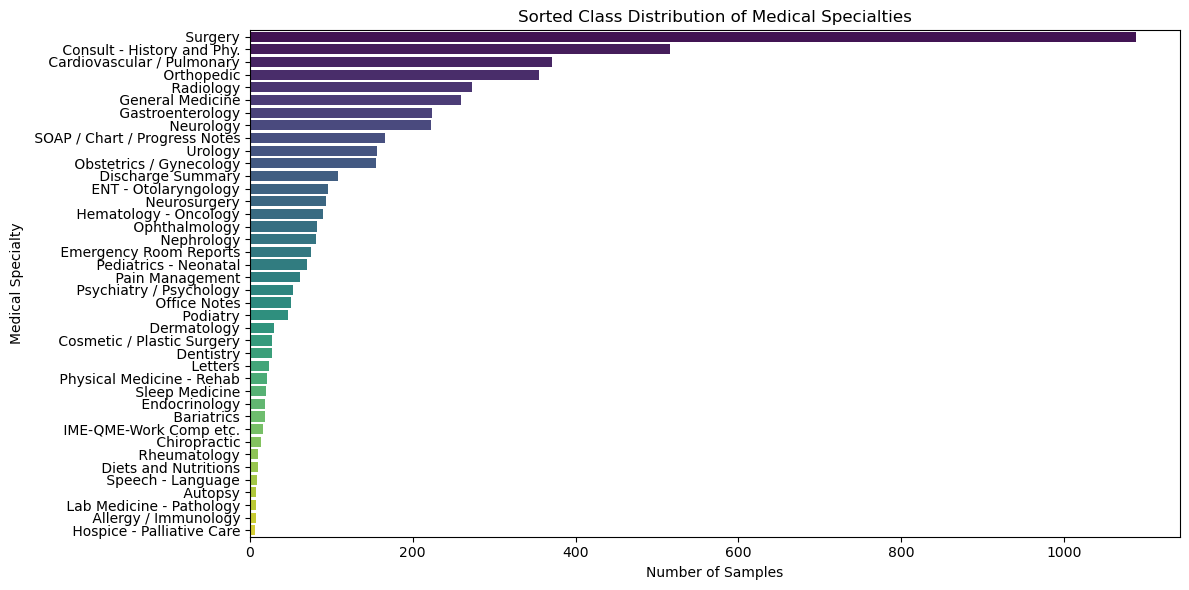

In [11]:
# Count and sort the classes
class_counts = df['medical_specialty'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
plt.title("Sorted Class Distribution of Medical Specialties")
plt.xlabel("Number of Samples")
plt.ylabel("Medical Specialty")
plt.tight_layout()
plt.show()

## Text Processing:
Initial steps included lowercasing, removal of punctuation, and elimination of stop words. Tokenization and lemmatization have been successfully implemented using the Punkt tokenizer.

In [213]:
# Define the stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words and filter out stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Retain only unique words
    unique_words = set(filtered_words)
    
    return ' '.join(unique_words)

In [215]:
df['cleaned_transcription'] = df['transcription'].apply(preprocess_text)

## Feature Extraction
Convert text into numerical format using TF-IDF Vectorization.

In [15]:
#Use TF-IDF to identify important terms within each medical specialty.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10)

# Fit and transform the cleaned transcriptions
X_tfidf = vectorizer.fit_transform(df['cleaned_transcription'])

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()


In [16]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=terms)

# Add the medical specialty column
tfidf_df['medical_specialty'] = df['medical_specialty']

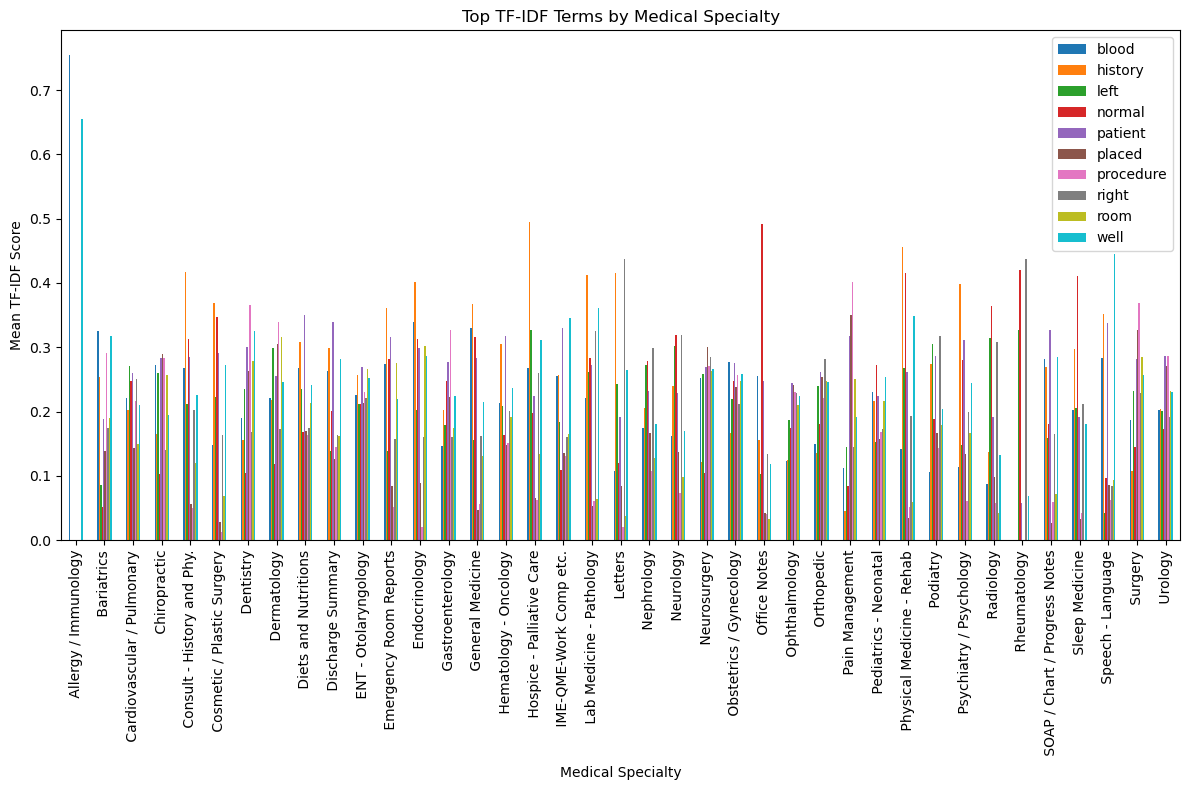

In [17]:
#Plot the most common used words against the medical specialty using the TFIDF Score 

# Group by medical specialty and calculate mean TF-IDF scores
mean_tfidf = tfidf_df.groupby('medical_specialty').mean()

# Plot the top terms for each specialty
mean_tfidf.plot(kind='bar', figsize=(12, 8))
plt.title('Top TF-IDF Terms by Medical Specialty')
plt.ylabel('Mean TF-IDF Score')
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### PREP: Import + Vectorization (TF-IDF)

In [20]:
# Encode the target variable
label_encoder = LabelEncoder()
df['medical_specialty'] = label_encoder.fit_transform(df['medical_specialty'])

# Text Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['cleaned_transcription']).toarray()
y = df['medical_specialty']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model
Using Logistic Regression as baseline model

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, y_pred_lr, zero_division=1))

Logistic Regression Results:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       1.00      0.00      0.00         1
           2       1.00      0.00      0.00         2
           3       0.26      0.24      0.25        79
           4       1.00      0.00      0.00         2
           5       0.27      0.54      0.36       111
           6       1.00      0.00      0.00         7
           7       1.00      0.00      0.00         8
           8       1.00      0.00      0.00         2
           9       1.00      0.00      0.00         1
          10       0.31      0.22      0.26        23
          11       1.00      0.00      0.00        32
          12       1.00      0.00      0.00        13
          13       1.00      0.00      0.00         2
          14       0.00      0.00      0.00        45
          15       0.06      0.07      0.06        44
          16       0.00      0.00      0.00        

## Multiple models tested to compare accuracy before sampling.

In [25]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
 }

# Train, predict, and store accuracy
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    

Logistic Regression Accuracy: 0.2757
Multinomial Naive Bayes Accuracy: 0.3773
Support Vector Machine Accuracy: 0.1610
Random Forest Accuracy: 0.0865


## Multiple Models using SMOTE  sampling.

In [32]:
#using SMOTE for resampling 
from imblearn.over_sampling import SMOTE

In [33]:
# Split before applying SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, stratify=y, random_state=42)



# Filter rare classes
min_class_size = 100
valid_classes = y_train.value_counts()[y_train.value_counts() >= min_class_size].index
X_train_filtered = X_train[y_train.isin(valid_classes)]
y_train_filtered = y_train[y_train.isin(valid_classes)]

# Apply SMOTE
smote = SMOTE(k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_filtered.toarray(), y_train_filtered
)

In [34]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB()
    # ,
    # 'Support Vector Machine': SVC(),
    # 'Random Forest': RandomForestClassifier()
}

# Train, predict, and store accuracy
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.2284
Multinomial Naive Bayes Accuracy: 0.3219
Support Vector Machine Accuracy: 0.1308
Random Forest Accuracy: 0.0785


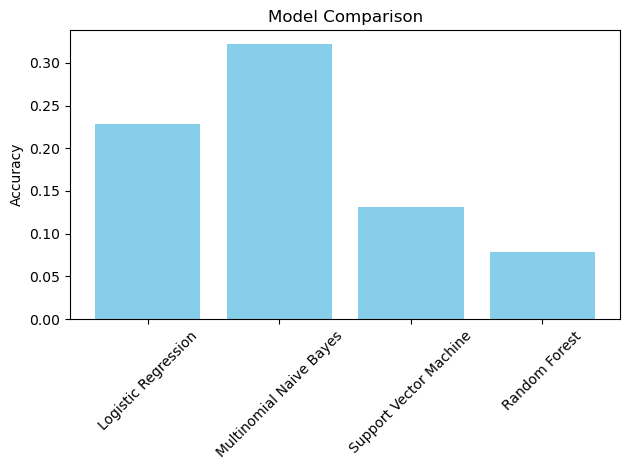

In [35]:
# Plot accuracy
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Multiple Models using Randam Over sampling.

In [27]:
# Define features and target
X = df['cleaned_transcription']  # or 'transcription' if you prefer full text
y = df['medical_specialty']  # assuming this is the target

from imblearn.over_sampling import RandomOverSampler

# Vectorize text
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_vec, y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [29]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Train, predict, and store accuracy
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.7931
Multinomial Naive Bayes Accuracy: 0.7798
Support Vector Machine Accuracy: 0.7943
Random Forest Accuracy: 0.7957


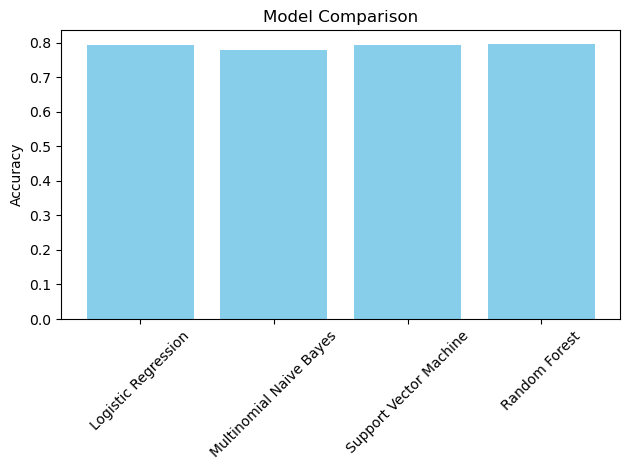

In [30]:
# Plot accuracy
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model 4: BERT (Transformers)

In [217]:
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from typing import Dict

# Filter rare classes (optional)
min_samples = 10
df = df[df["medical_specialty"].map(df["medical_specialty"].value_counts()) >= min_samples]

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["medical_specialty"])
num_labels = len(label_encoder.classes_)

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["cleaned_transcription"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [223]:
# Tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [224]:
# Dataset class
class ClinicalDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ClinicalDataset(train_encodings, train_labels)
val_dataset = ClinicalDataset(val_encodings, val_labels)

In [227]:
import torch
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [229]:
# Custom model class with weighted loss
class WeightedLossBERT(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.bert.classifier(outputs.pooler_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None
        )

In [ ]:
# Load custom model
model = WeightedLossBERT(model_name, num_labels, class_weights)

# Metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./clinicalbert_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [233]:
trainer.train()

Step,Training Loss
500,3.444900
1000,2.998400


TrainOutput(global_step=1479, training_loss=2.9559514353289806, metrics={'train_runtime': 8024.1369, 'train_samples_per_second': 1.474, 'train_steps_per_second': 0.184, 'total_flos': 0.0, 'train_loss': 2.9559514353289806, 'epoch': 3.0})

In [234]:
# Evaluate on validation set after training
eval_results = trainer.evaluate()

# Print metrics
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_results['eval_f1']:.4f}")

Validation Accuracy: 0.3256
Validation F1 Score: 0.2482


## Saving the finetuned model for future use

In [247]:
#Saving the fine tuned model
save_path = "./fine_tuned_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('./fine_tuned_model\\tokenizer_config.json',
 './fine_tuned_model\\special_tokens_map.json',
 './fine_tuned_model\\vocab.txt',
 './fine_tuned_model\\added_tokens.json',
 './fine_tuned_model\\tokenizer.json')

## Relaoding the model

In [ ]:
#Relaoding the model later for Inference

save_path = "./clinicalbert_output/checkpoint-1479"
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

### Predicted output

In [255]:
def predict(texts, model, tokenizer):
    model.eval()
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    return label_encoder.inverse_transform(preds)

# Example usage
text_sample = ["Patient with type 2 diabetes and elevated glucose."]
prediction = predict(text_sample, model, tokenizer)
print("Predicted Specialty:", prediction[0])

Predicted Specialty:  Cardiovascular / Pulmonary
